In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Critic model configuration
clipping_param = 0.01

# Training configuration
device = torch.device("cuda:0")
batch_size = 64
real_label = -1.0
fake_label = 1.0
n_epochs = 10
n_critic = 5

# Loss weight for gradient penalty
use_gp = True
lambda_gp = 10

# Dataset configuration
image_size = 28
num_workers = 16

In [3]:
def weight_init_critic(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [4]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        # input_shape = 28
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x 28 x 28
                nn.Conv2d(1, 8, 4, stride=2, padding=3),
                nn.LeakyReLU(0.2),
                # input: 8 x 16 x 16
                nn.Conv2d(8, 16, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 16 x 8 x 8
                nn.Conv2d(16, 32, 4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # input: 32 x 4 x 4
                nn.Conv2d(32, 1, 4, stride=1, padding=0),
                # output: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x 28 x 28
                nn.Conv2d(1, 8, 4, stride=2, padding=3),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(0.2),
                # input: 8 x 16 x 16
                nn.Conv2d(8, 16, 4, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.2),
                # input: 16 x 8 x 8
                nn.Conv2d(16, 32, 4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2),
                # input: 32 x 4 x 4
                nn.Conv2d(32, 1, 4, stride=1, padding=0),
                # output: 1 x 1 x 1
            )
    
    def forward(self, input):
        return self.main(input)

In [5]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init_critic)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [6]:
def weight_init_generator(m):
    if isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [7]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: 100 x 1 x 1
            nn.ConvTranspose2d(100, 64, 4, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # input: 64 x 4 x 4
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            # input: 32 x 8 x 8
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # input: 16 x 16 x 16
            nn.ConvTranspose2d(16, 1, 4, 2, 3),
            nn.Tanh()
            # output: 1 x 28 x 28
        )
    
    def forward(self, input):
        return self.main(input)

In [8]:
generator_model = Generator().to(device)
generator_model.apply(weight_init_generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
    (10): Tanh()
  )
)

In [9]:
dataset = torchvision.datasets.MNIST(
    root="mnist_root_dir",
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
)
filter_digit = 8
idx = dataset.targets == filter_digit
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

(-0.5, 27.5, 27.5, -0.5)

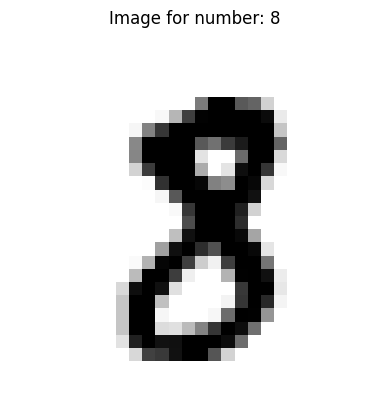

In [10]:
dummy_batch = next(iter(dataloader))
plt.imshow(dummy_batch[0][23][0], cmap="gray_r")
plt.title(f"Image for number: {dummy_batch[1][23]}")
plt.axis("off")

In [11]:
optimizer_critic = optim.RMSprop(critic_model.parameters(), lr=5e-5)
optimizer_generator = optim.RMSprop(generator_model.parameters(), lr=5e-5)

In [12]:
# Training loop
print("Starting training....")
d_loss_hist = list()
g_loss_hist = list()
print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data[0].to(device)
        b_size = real_batch.shape[0]

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)

        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

    # Summarize performance every epoch
    if not epoch % 1:
        tqdm.write(f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f}")

Starting training....
Number of mini batch iterations per epoch: 92


0it [00:00, ?it/s]MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_14.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
92it [00:32,  2.79it/s]

epoch: 0, d_loss: -46.2468, g_loss: -87.4146



92it [00:08, 10.38it/s]

epoch: 1, d_loss: -169.5318, g_loss: -432.3961



92it [00:08, 10.40it/s]

epoch: 2, d_loss: -295.9826, g_loss: -1354.9689



92it [00:08, 10.54it/s]

epoch: 3, d_loss: -72.1123, g_loss: -1846.3652



92it [00:08, 11.08it/s]

epoch: 4, d_loss: -61.2996, g_loss: -1413.2682



92it [00:08, 11.17it/s]

epoch: 5, d_loss: -69.4700, g_loss: -1229.3959



92it [00:08, 11.03it/s]

epoch: 6, d_loss: -63.9346, g_loss: -1033.5455



92it [00:08, 11.05it/s]


epoch: 7, d_loss: -48.6964, g_loss: -906.6110


92it [00:08, 11.00it/s]

epoch: 8, d_loss: -57.3464, g_loss: -863.0995



92it [00:08, 10.94it/s]

epoch: 9, d_loss: -79.5979, g_loss: -845.4300


In [13]:
def plot_history(d_loss_hist, g_loss_hist):
	# plot history
	plt.plot(d_loss_hist, label='d_loss')
	plt.plot(g_loss_hist, label='g_loss')
	plt.legend()
	plt.savefig('loss_wgan_clamp.png')
	plt.close()

In [14]:
plot_history(d_loss_hist, g_loss_hist)

In [15]:
def generate_fake_images():
    # Generate 100 fake images
    noise = torch.randn(100, 100, 1, 1, device=device)
    output = generator_model(noise)
    output = output.detach().cpu()
    output = (output + 1) / 2
    plt.clf()
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.axis("off")
        plt.imshow(output[i, 0, :, :], cmap="gray_r")
    plt.savefig("fake_images_wgan_clamp.png")
    plt.close()
    return output

In [16]:
_ = generate_fake_images()